<a href="https://colab.research.google.com/github/moarshy/PyTorch_fastai_Projects/blob/main/fastai_tabular_adult_chap9fastbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The intention of this notebook is to practice [Chapter 9](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb) of fastbook (by fast.ai) which is on working with Tabular data

This [Dataset](https://www.kaggle.com/wenruliu/adult-income-dataset) was used in this practice notebook
> 1. this is a classification task using structured/tabular data
> 2. we are predict if the salary above/below 50k given the features such as age

This [blog](https://walkwithfastai.com/tab.clas.binary) also helpful

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip uninstall fastai -q -y
!pip install fastai -q 

     |████████████████████████████████| 194kB 5.7MB/s 
     |████████████████████████████████| 61kB 5.3MB/s 


In [3]:
!pip install dtreeviz -q

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 204.2MB 78kB/s 
     |████████████████████████████████| 204kB 38.8MB/s 


In [4]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

# Loading and exploring the data

In [5]:
base_path = Path('/content/drive/My Drive/colab_notebooks/Portfolio/Tabular/Adult')


In [6]:
df = pd.read_csv(base_path/'adult_sample/adult.csv')

In [7]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32561 non-null  int64  
 1   workclass       32561 non-null  object 
 2   fnlwgt          32561 non-null  int64  
 3   education       32561 non-null  object 
 4   education-num   32074 non-null  float64
 5   marital-status  32561 non-null  object 
 6   occupation      32049 non-null  object 
 7   relationship    32561 non-null  object 
 8   race            32561 non-null  object 
 9   sex             32561 non-null  object 
 10  capital-gain    32561 non-null  int64  
 11  capital-loss    32561 non-null  int64  
 12  hours-per-week  32561 non-null  int64  
 13  native-country  32561 non-null  object 
 14  salary          32561 non-null  object 
dtypes: float64(1), int64(5), object(9)
memory usage: 3.7+ MB


In [9]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

In [10]:
dep_var = 'salary'

In [11]:
df.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
salary                2
dtype: int64

In [12]:
# Deciding categorical and continuous features
# fastai's helper function cont_cat_split can be used to split cat and cont columns
# Below is the funtion that does this --> simple way
'''
def cont_cat_split(df, max_card=20, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for label in df:
        if label in L(dep_var): continue
        if df[label].dtype == int and df[label].unique().shape[0] > max_card or df[label].dtype == float:
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names
'''

'\ndef cont_cat_split(df, max_card=20, dep_var=None):\n    "Helper function that returns column names of cont and cat variables from given `df`."\n    cont_names, cat_names = [], []\n    for label in df:\n        if label in L(dep_var): continue\n        if df[label].dtype == int and df[label].unique().shape[0] > max_card or df[label].dtype == float:\n            cont_names.append(label)\n        else: cat_names.append(label)\n    return cont_names, cat_names\n'

In [13]:
cont,cat = cont_cat_split(df, 5, dep_var=dep_var)

In [14]:
print(cont); print(cat)

['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


# Handling missing values and categorical features

Both can be easily handled with fastai

In [15]:
splits = RandomSplitter()(range_of(df))

In [16]:
procs = [Categorify, FillMissing]
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [17]:
len(to.train),len(to.valid)


(26049, 6512)

In [18]:
to.show(3)


,workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary
15834,Private,HS-grad,Divorced,Exec-managerial,Unmarried,White,Female,United-States,False,35,170263,9.0,0,0,40,<50k
26539,Local-gov,Assoc-voc,Never-married,Protective-serv,Unmarried,White,Male,United-States,False,48,81154,11.0,0,0,48,<50k
24584,Private,HS-grad,Never-married,Machine-op-inspct,Not-in-family,White,Female,United-States,False,51,348099,9.0,0,1590,40,<50k


In [19]:
to.items.head(3)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,education-num_na
15834,35,5,170263,12,9.0,1,5,5,5,1,0,0,40,40,0,1
26539,48,3,81154,9,11.0,5,12,5,5,2,0,0,48,40,0,1
24584,51,5,348099,12,9.0,5,8,2,5,1,0,1590,40,40,0,1


In [20]:
to.classes

{'education': ['#na#', ' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college'],
 'education-num_na': ['#na#', False, True],
 'marital-status': ['#na#', ' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed'],
 'native-country': ['#na#', ' ?', ' Cambodia', ' Canada', ' China', ' Columbia', ' Cuba', ' Dominican-Republic', ' Ecuador', ' El-Salvador', ' England', ' France', ' Germany', ' Greece', ' Guatemala', ' Haiti', ' Holand-Netherlands', ' Honduras', ' Hong', ' Hungary', ' India', ' Iran', ' Ireland', ' Italy', ' Jamaica', ' Japan', ' Laos', ' Mexico', ' Nicaragua', ' Outlying-US(Guam-USVI-etc)', ' Peru', ' Philippines', ' Poland', ' Portugal', ' Puerto-Rico', ' Scotland', ' South', ' Taiwan', ' Thailand', ' Trinadad&Tobago', ' United-States', ' Vietnam', ' Yugoslavia'],
 '

In [21]:
to.classes['workclass']

['#na#', ' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay']

In [22]:
save_pickle(base_path/'to.pkl',to)

# Decision trees

For tabular/structured data, two methods work very well
> 1. Ensembles of decision trees
> 2. Multilayered neural networks learned with SGD

Let's try DecisionTreeClassifier



In [23]:
to = load_pickle(base_path/'to.pkl')


In [24]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [25]:
m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(xs, y);

In [37]:
def accuracy (preds, targets):
    return round((preds == targets.values).sum() / len(preds), 4)

In [38]:
preds = m.predict(valid_xs)

In [40]:
# in the first round of this we achieve 82.7% accuracy
accuracy(preds, valid_y)

0.8271

In [41]:
m.get_n_leaves(), len(xs)

(4, 26049)

In [43]:
# lets try without the max_leaf_nodes
m = DecisionTreeClassifier()
m.fit(xs, y)
preds = m.predict(valid_xs)

In [44]:
# results are worse off
accuracy(preds, valid_y)

0.8151

In [46]:
# results of worse cuz of overfitting; lets look at the number of leaves
m.get_n_leaves(), len(xs)

(3829, 26049)

In [48]:
m = DecisionTreeClassifier(min_samples_leaf=25)
m.fit(xs, y)
preds = m.predict(valid_xs)

In [50]:
# much better results --> results improved about 3% points
accuracy(preds, valid_y)

0.8518

In [52]:
#much less leaves
m.get_n_leaves(), len(xs)

(514, 26049)

# Next lets try RandomForest
RandomForest involves "bagging"

This is what this involves as explained in fastbook

>Here is the procedure that Breiman is proposing:
>
>*   Randomly choose a subset of the rows of your data (i.e., "bootstrap >replicates of your learning set").
>*   Train a model using this subset.
>*   Save that model, and then return to step 1 a few times.
>*   This will give you a number of trained models. To make a prediction, >predict using all of the models, and then take the average of each of those >model's predictions.

In [55]:
def rf(xs, y, n_estimators=40, max_samples=15000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [56]:
m = rf(xs, y)

In [58]:
preds = m.predict(valid_xs)

In [60]:
# this further improves our model
accuracy(preds, valid_y)

0.8619

In [63]:
#OOB (out-of-bag) error; 
#a way of measuring prediction error on the training set by only including in the calculation of a row's error trees where that row was not included in training
m.oob_decision_function_

array([[0.95064103, 0.04935897],
       [0.83428571, 0.16571429],
       [0.96407313, 0.03592687],
       ...,
       [0.97006803, 0.02993197],
       [0.97619048, 0.02380952],
       [0.64124692, 0.35875308]])

In [71]:
accuracy(np.argmax(m.oob_decision_function_, axis=1), y)

0.8613

# Model interpretation


*   How confident are we in our predictions using a particular row of data?
*   For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
*   Which columns are the strongest predictors, which can we ignore?
*   Which columns are effectively redundant with each other, for purposes of prediction?
*   How do predictions vary, as we vary these columns?



In [72]:
#Tree Variance for Prediction Confidence
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [74]:
preds.shape

(40, 6512)

In [79]:
preds_std = preds.std(0)
preds_std

array([0.15612495, 0.3       , 0.41758233, ..., 0.        , 0.        ,
       0.        ])

In [80]:

preds_std[:5]

array([0.15612495, 0.3       , 0.41758233, 0.        , 0.4330127 ])

In [81]:
#Feature Importance
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [84]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
4,relationship,0.191282
12,capital-gain,0.172170
11,education-num,0.138838
9,age,0.105670
10,fnlwgt,0.093767
2,marital-status,0.083462
14,hours-per-week,0.060547
3,occupation,0.048106
13,capital-loss,0.037883
1,education,0.026078


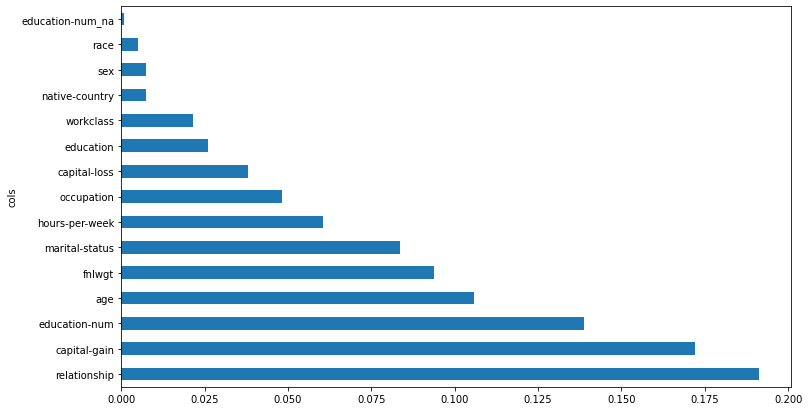

In [86]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi);

In [89]:
#some of the top features do make sense for eg - age, education
#others are interesting marital-status, relationship

In [90]:
#Removing Low-Importance Variable

In [98]:
to_keep = fi[fi.imp>0.03].cols
len(to_keep)

9

In [100]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [101]:
m = rf(xs_imp, y)

In [102]:
preds = m.predict(valid_xs_imp)

In [104]:
#our accuracy dropped a little
accuracy(preds, valid_y)

0.858

In [108]:
def get_oob(df):
    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=15,
        max_samples=15000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [109]:
get_oob(xs_imp)

0.8591116741525586

In [110]:
xs.columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'education-num_na',
       'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [111]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (xs_imp.columns)}

{'age': 0.8550040308649084,
 'capital-gain': 0.8390725171791623,
 'capital-loss': 0.8533532957119275,
 'education-num': 0.852892625436677,
 'fnlwgt': 0.8598794579446428,
 'hours-per-week': 0.8581519444124535,
 'marital-status': 0.8591116741525586,
 'occupation': 0.8558869822258052,
 'relationship': 0.856040538984222}

In [112]:
from sklearn.inspection import plot_partial_dependence

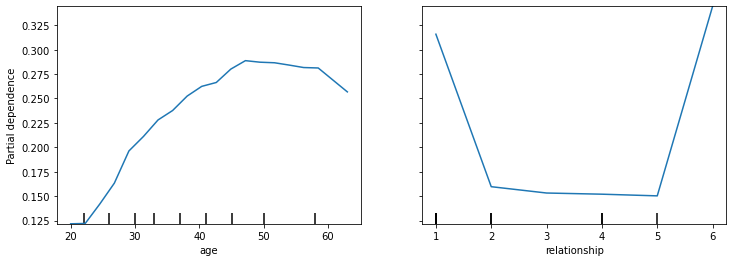

In [113]:
fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_imp, ['age','relationship'],
                        grid_resolution=20, ax=ax)

# Using a Neural Network¶

In [140]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs_nn, cat, cont, splits=splits, y_names=dep_var, y_block=CategoryBlock())

In [141]:
dls = to_nn.dataloaders(512)

In [146]:
learn = tabular_learner(dls, layers=[500,250], metrics=[error_rate, fastai.metrics.accuracy])

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0014454397605732083)

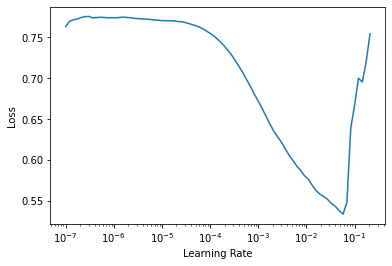

In [147]:
learn.lr_find()

In [149]:
learn.fit_one_cycle(10, 0.0025)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.286685,0.315723,0.145424,0.854576,00:02
1,0.294906,0.322903,0.149109,0.850891,00:02
2,0.301398,0.320350,0.148034,0.851966,00:02
3,0.299279,0.329475,0.149109,0.850891,00:02
4,0.294076,0.324246,0.145270,0.854730,00:02
5,0.286069,0.325171,0.149570,0.850430,00:02
6,0.275616,0.330118,0.151259,0.848741,00:02
7,0.268440,0.327221,0.148956,0.851044,00:02
8,0.256640,0.329452,0.148188,0.851812,00:02
9,0.248446,0.330758,0.149724,0.850276,00:02
